# 1. Kütüphaneleri Yükleme
Bu bölümde gerekli tüm kütüphaneleri yüklüyoruz:
- `torch/torchvision`: PyTorch ve VGG-16 modeli
- `matplotlib/seaborn`: görselleştirme
- `sklearn`: metrikler
- `cv2`: Grad-CAM için


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, random_split, Subset
from torchvision import datasets, transforms
from collections import Counter
from torchvision.models import vgg16, VGG16_Weights

from sklearn.metrics import confusion_matrix, classification_report


# 2. GPU Kontrolü
Google Colab / Kaggle GPU desteğini otomatik algılar.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")


Kullanılan cihaz: cuda


# 3. Veri Setini İnceleme
- Sınıf isimlerini listeliyoruz  
- Her sınıftaki görüntü sayısını yazdırıyoruz  
- Örnek bir MR görüntüsü gösteriyoruz  
- Sınıf dağılımını bar plot ile görselleştiriyoruz


Sınıflar: ['pituitary', 'notumor', 'meningioma', 'glioma']
pituitary: 1457 görüntü
notumor: 1595 görüntü
meningioma: 1339 görüntü
glioma: 1321 görüntü


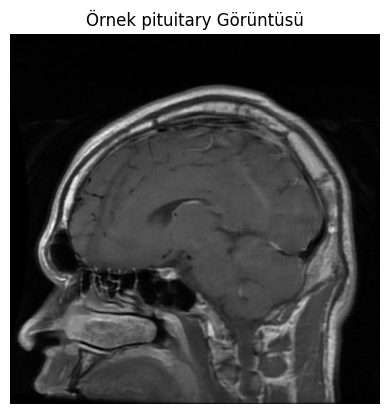

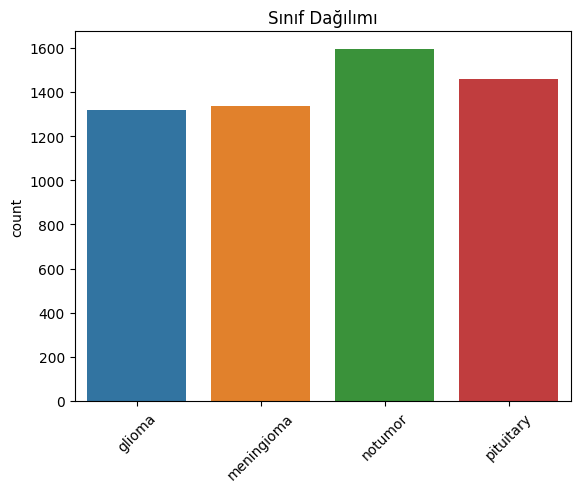

In [3]:
base_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
classes = os.listdir(base_dir)
print("Sınıflar:", classes)

# Her sınıftaki görüntü sayısı
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} görüntü")

# Örnek görüntü
sample_img_path = os.path.join(base_dir, classes[0], os.listdir(os.path.join(base_dir, classes[0]))[0])
sample_img = plt.imread(sample_img_path)
plt.imshow(sample_img, cmap='gray')
plt.title(f"Örnek {classes[0]} Görüntüsü")
plt.axis('off')
plt.show()

# Sınıf dağılımı
labels = []
for cls in classes:
    labels.extend([cls] * len(os.listdir(os.path.join(base_dir, cls))))

sns.countplot(x=labels, order=np.unique(labels))
plt.title("Sınıf Dağılımı")
plt.xticks(rotation=45)
plt.show()


# 4. Veri Artırma (Data Augmentation)
Bu bölümde veri artırma yöntemleri tanımlıyoruz:
- `RandomRotation`
- `RandomHorizontalFlip`
- `RandomNoise` (özel yazıldı)  
Ayrıca train/val/test setlerini oluşturuyoruz.


In [4]:
# ---- Custom RandomNoise ----
class RandomNoise(object):
    def __init__(self, noise_level=0.05):
        self.noise_level = noise_level
    def __call__(self, img):
        noise = torch.randn_like(img) * self.noise_level
        return img + noise

# ---- CustomConcatDataset ----
class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)
        base = datasets[0].dataset if isinstance(datasets[0], Subset) else datasets[0]
        self.classes = base.classes
        self.dataset = base

# ---- Transform Pipelines ----
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
rot_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
flip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
noise_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    RandomNoise(noise_level=0.1),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---- Base Dataset ----
base_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"  # Pathini buraya ayarla
full_dataset = datasets.ImageFolder(base_dir, transform=original_transform)

# ---- Train/Val/Test Split ----
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Original -> Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

# ---- Class Balance Hesaplama ----
# train_set indices -> class dağılımı
train_labels = [full_dataset.samples[i][1] for i in train_set.indices]
class_counts = Counter(train_labels)
max_count = max(class_counts.values())

print("Class distribution in Train before aug:", class_counts)

# ---- Augment edilmiş datasetler ----
rot_dataset = datasets.ImageFolder(base_dir, transform=rot_transform)
flip_dataset = datasets.ImageFolder(base_dir, transform=flip_transform)
noise_dataset = datasets.ImageFolder(base_dir, transform=noise_transform)

balanced_subsets = [train_set]  # orijinal train dahil

# Her sınıf için dengeleme
for cls_idx in range(len(full_dataset.classes)):
    cls_indices = [i for i in train_set.indices if full_dataset.samples[i][1] == cls_idx]
    deficit = max_count - len(cls_indices)  # eksik sayısı

    if deficit > 0:
        # Deficit kadar augment ekle (rotation + flip + noise)
        aug_indices = np.random.choice(cls_indices, size=deficit, replace=True)

        rot_subset = Subset(rot_dataset, aug_indices)
        flip_subset = Subset(flip_dataset, aug_indices)
        noise_subset = Subset(noise_dataset, aug_indices)

        balanced_subsets.extend([rot_subset, flip_subset, noise_subset])

# ---- Final Balanced Train ----
augmented_train = CustomConcatDataset(balanced_subsets)

print(f"Final Train size (balanced with augmentation): {len(augmented_train)}")

# ---- Dataloaders ----
train_loader = DataLoader(augmented_train, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Original -> Train: 3998, Val: 856, Test: 858
Class distribution in Train before aug: Counter({2: 1128, 3: 1025, 1: 923, 0: 922})
Final Train size (balanced with augmentation): 5540


# 5. Örnek Görseller
Eğitim/validasyon/test setlerinden örnek görselleri çiziyoruz.


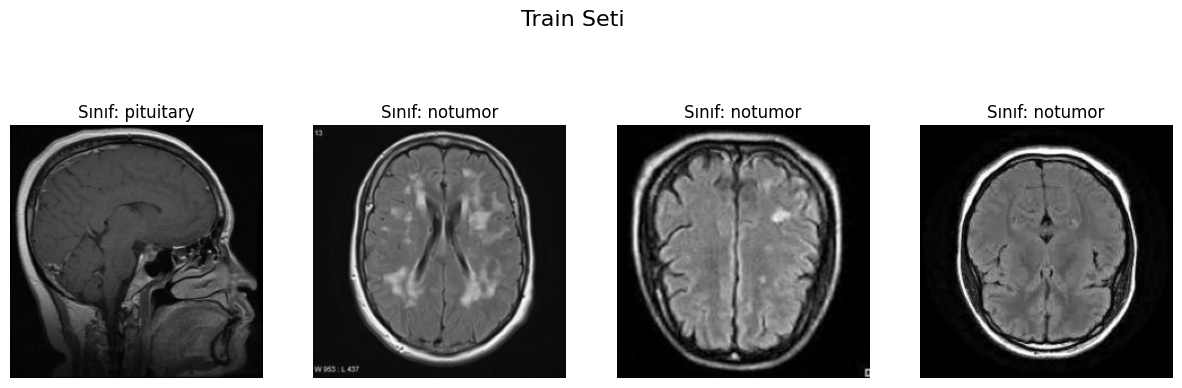

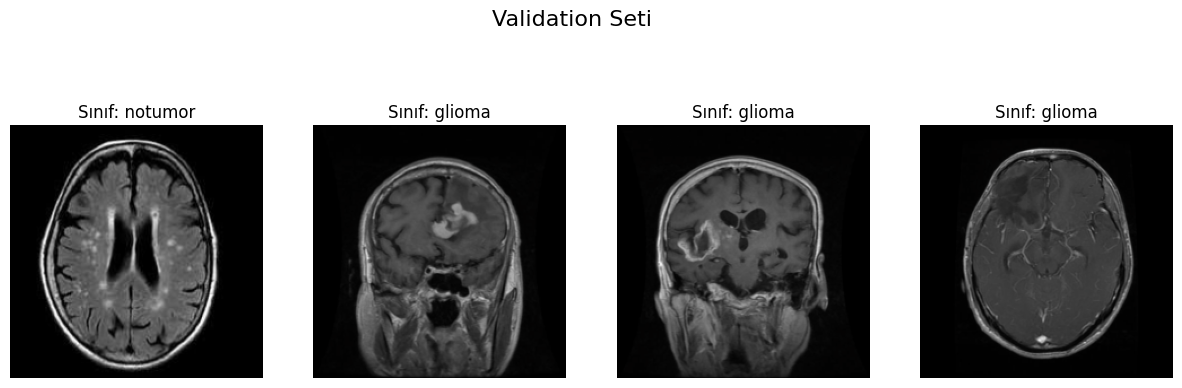

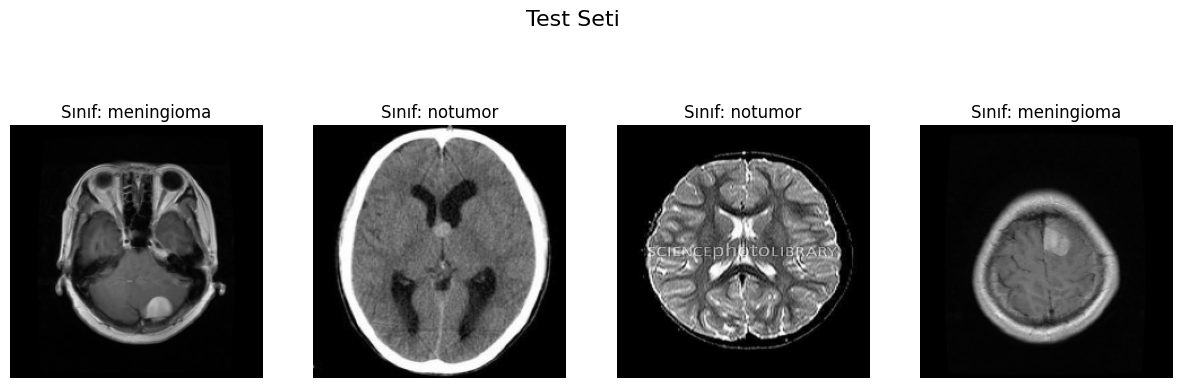

In [5]:
def show_images_from_dataset(dataset, title, num_images=4):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    indices = torch.randperm(len(dataset))[:num_images]

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        image = image * std + mean
        img_np = image.permute(1,2,0).numpy()

        plt.subplot(1, num_images, i+1)
        plt.imshow(img_np)
        plt.title(f"Sınıf: {dataset.dataset.classes[label]}")
        plt.axis('off')
    plt.show()

show_images_from_dataset(train_set, "Train Seti")
show_images_from_dataset(val_set, "Validation Seti")
show_images_from_dataset(test_set, "Test Seti")


# 6. VGG-16 Modeli
Güncel weights parametresi ile VGG-16’yı yüklüyoruz.


In [6]:
vgg = vgg16(weights=VGG16_Weights.DEFAULT)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 4)
vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 205MB/s] 


# 7. Modeli Eğitme
20 epoch boyunca train ve validation performanslarını kaydediyoruz.


In [7]:
# Kayıp fonksiyonu (CrossEntropy)
criterion = nn.CrossEntropyLoss()

# Adam optimizer + L2 regularization (weight decay)
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001, weight_decay=1e-4)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    # ---- Eğitim ----
    vgg.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)   # CrossEntropy + L2 (otomatik ekleniyor)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # ---- Validation ----
    vgg.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg(inputs)
            loss = criterion(outputs, labels)  # burada da L2 cezası var (optimizere bağlı)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    # ---- Epoch Sonucu ----
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, "
          f"Train Acc: {train_accs[-1]*100:.2f}%, Val Acc: {val_accs[-1]*100:.2f}%")


Epoch 1/20, Train Loss: 1.077, Val Loss: 0.995, Train Acc: 50.63%, Val Acc: 52.57%
Epoch 2/20, Train Loss: 0.677, Val Loss: 0.529, Train Acc: 71.01%, Val Acc: 81.19%
Epoch 3/20, Train Loss: 0.601, Val Loss: 0.819, Train Acc: 75.63%, Val Acc: 69.39%
Epoch 4/20, Train Loss: 0.500, Val Loss: 0.517, Train Acc: 80.07%, Val Acc: 80.84%
Epoch 5/20, Train Loss: 0.398, Val Loss: 0.433, Train Acc: 84.13%, Val Acc: 84.93%
Epoch 6/20, Train Loss: 0.364, Val Loss: 0.552, Train Acc: 86.41%, Val Acc: 78.50%
Epoch 7/20, Train Loss: 0.390, Val Loss: 0.386, Train Acc: 85.20%, Val Acc: 85.75%
Epoch 8/20, Train Loss: 0.302, Val Loss: 0.330, Train Acc: 88.32%, Val Acc: 89.14%
Epoch 9/20, Train Loss: 0.333, Val Loss: 0.308, Train Acc: 87.98%, Val Acc: 89.25%
Epoch 10/20, Train Loss: 0.241, Val Loss: 0.359, Train Acc: 91.39%, Val Acc: 86.80%
Epoch 11/20, Train Loss: 0.240, Val Loss: 0.348, Train Acc: 91.08%, Val Acc: 88.67%
Epoch 12/20, Train Loss: 0.219, Val Loss: 0.325, Train Acc: 92.02%, Val Acc: 89.72%
E

# 8. Sonuçları Görselleştirme
Loss ve Accuracy grafikleri + Test seti performansı.


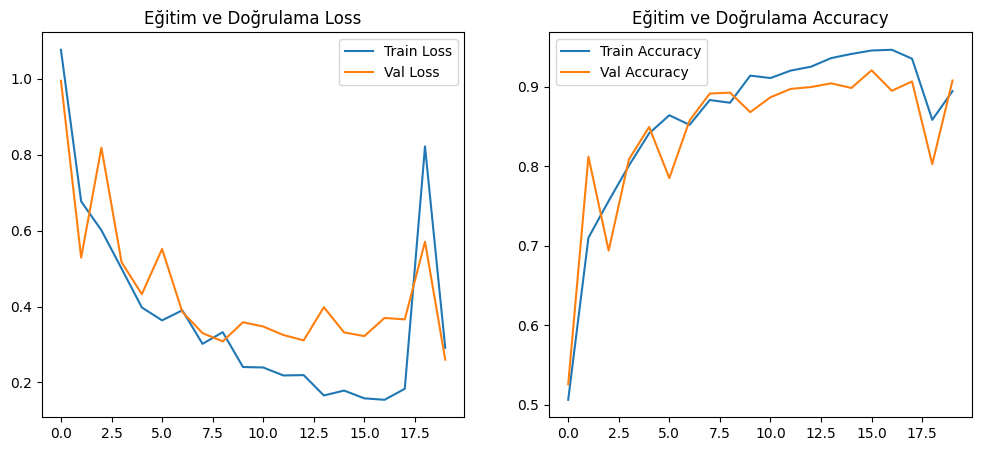

Test Accuracy: 91.14%, Test Loss: 0.281


In [8]:
# Eğitim grafikleri
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Eğitim ve Doğrulama Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title("Eğitim ve Doğrulama Accuracy")
plt.legend()
plt.show()

# Test değerlendirmesi
vgg.eval()
all_preds, all_labels = [], []
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_acc*100:.2f}%, Test Loss: {test_loss:.3f}")


# 9. Grad-CAM Görselleştirme
Bir test görüntüsünde modelin hangi bölgeleri dikkate aldığını gösteriyoruz.


Gerçek: glioma, Tahmin: glioma


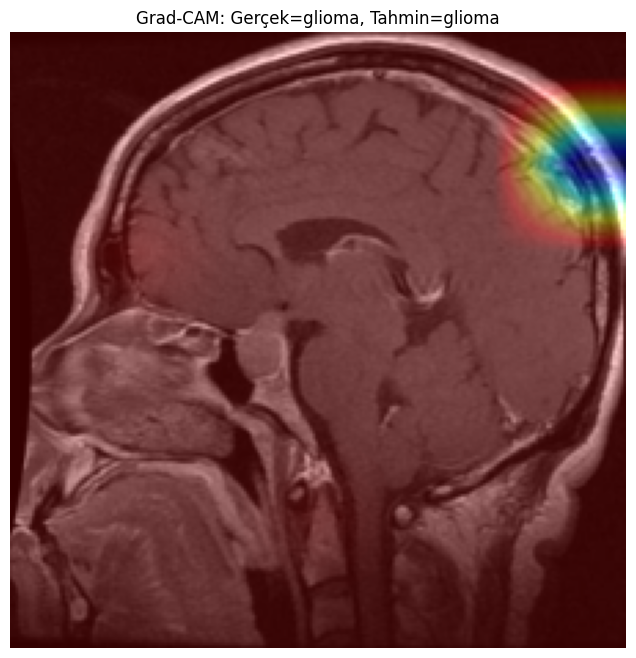

In [9]:
inputs, labels = next(iter(test_loader))
input_img = inputs[0].unsqueeze(0).to(device)
label = labels[0].item()

gradients, activations = None, None
def save_backward(module, grad_in, grad_out):
    global gradients; gradients = grad_out[0]
def save_forward(module, input, output):
    global activations; activations = output

target_layer = vgg.features[-1]
target_layer.register_forward_hook(save_forward)
target_layer.register_backward_hook(save_backward)

input_img.requires_grad_()
output = vgg(input_img)
pred_idx = output.argmax(dim=1).item()
print(f"Gerçek: {classes[label]}, Tahmin: {classes[pred_idx]}")

output[0, pred_idx].backward()

gradients = gradients[0].cpu().detach().numpy()
activations = activations[0].cpu().detach().numpy()
weights = np.mean(gradients, axis=(1,2))

cam = np.zeros(activations.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * activations[i]
cam = np.maximum(cam,0)
cam = cv2.resize(cam, (224,224))
cam /= cam.max()

img = inputs[0].cpu().numpy().transpose(1,2,0)
img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
img = np.clip(img,0,1)

heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap)/255
overlay = np.clip(heatmap*0.4 + img,0,1)

plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.title(f"Grad-CAM: Gerçek={classes[label]}, Tahmin={classes[pred_idx]}")
plt.axis('off')
plt.show()


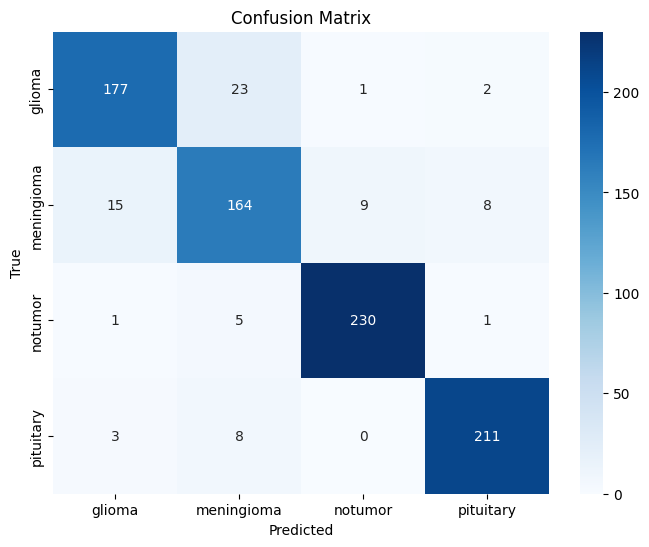

Classification Report:
              precision    recall  f1-score   support

      glioma       0.90      0.87      0.89       203
  meningioma       0.82      0.84      0.83       196
     notumor       0.96      0.97      0.96       237
   pituitary       0.95      0.95      0.95       222

    accuracy                           0.91       858
   macro avg       0.91      0.91      0.91       858
weighted avg       0.91      0.91      0.91       858



In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ---- Model Evaluation on Test ----
vgg.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- Classification Report ----
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))
